# Introduction
The aim is to implement a ML solution that will perform better than the provided example jupyter notebook that utilises basic logistic regression from the scikit module. The data was scaled and then fit into that model. The following results were obtained:
# LogisticRegression
## LogisticRegression (34 classes)
accuracy_score:  0.802\
recall_score:  0.595\
precision_score:  0.487\
f1_score:  0.494

## LogisticRegression (8 classes)
accuracy_score =  0.832\
recall_score =  0.696\
precision_score =  0.512\
f1_score =  0.539

## LogisticRegression (2 classes)
accuracy_score:  0.989\
recall_score:  0.890\
precision_score:  0.864\
f1_score:  0.877

# SGD
## SGD (34 classes)
accuracy_score:  0.7860381477619159
recall_score:  0.5179118961920882
precision_score:  0.42184457529453795
f1_score:  0.4256465870416849

## SGD (8 classes)
accuracy_score =  0.8226369976250854
recall_score =  0.68058577451911
precision_score =  0.4617525150801485
f1_score =  0.49719100438594754

## SGD (2 classes)
accuracy_score:  0.9868773803425305
recall_score:  0.8686111308207715
precision_score:  0.8334084807767805
f1_score:  0.8500759333973384


It is worth noting that good accuracy score in this case is not a good metric due to high amount of malicious packet data compared to benign. To combat that, it is better to look at score metrics such as recall, precision and f1. Furthermore, duplication of benign entries is an option, but might not be a correct option due to the actual nature of DDoS attacks having very big amount of packets compared to normal benign traffic.

# Coding
## Importing packages and dataset

In [82]:
import pandas as pd
import numpy as np
import os
from tqdm.autonotebook import tqdm
import warnings
warnings.filterwarnings('ignore')
DATASET_DIR = r'../CICIoT2023'

In [83]:
df_sets = [DATASET_DIR + '/' + k for k in os.listdir(DATASET_DIR) if k.endswith('.csv')]
df_sets.sort()
# Data is too large to parse as a single pd
index_range = range(len(df_sets))
import random
SEED = 42  # Set to None for randomness
if SEED:
    random.seed(SEED)
    print(f"INFO: Using seed {SEED}")
else:
    print(f"Using random seed")
CLASSES = 7 ## Valid values are 34, 7 or 2
if CLASSES not in (34, 7, 2):
    print("Please set a valid number of classes (34, 7, 2)")
    exit(1)
else:
    print(f"INFO: Using {CLASSES} classes")
# Manual train/test splitting
test_indexes_count = int(len(df_sets)*0.2)
train_indexes_count = int(len(df_sets)*0.8)
test_indexes = random.sample(index_range, test_indexes_count)
train_indexes = [i for i in index_range if i not in test_indexes][:train_indexes_count]
test_data, train_data = [], []
print(test_indexes)
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
    'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
    'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
    'ece_flag_number', 'cwr_flag_number', 'ack_count',
    'syn_count', 'fin_count', 'urg_count', 'rst_count', 
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
    'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
    'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
    'Radius', 'Covariance', 'Variance', 'Weight', 
]
y_column = 'label'
# DROP_COLS = ['SMTP', 'Drate', 'IRC', 'DHCP', 'Telnet', 'ece_flag_number', 'cwr_flag_number', 'ARP', 'IPv', 'LLC', 'DNS', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'ICMP', 'HTTP', 'psh_flag_number']

INFO: Using seed 42
INFO: Using 7 classes
[163, 28, 6, 70, 62, 57, 35, 26, 139, 22, 151, 108, 8, 7, 23, 55, 59, 129, 166, 143, 50, 160, 107, 56, 114, 71, 1, 40, 157, 87, 149, 39, 153]


## Scaling the data

In [84]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

count = 37616542

## Initialise pytorch and check if GPU is available

In [85]:
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
import gc
gc.collect()
torch.cuda.empty_cache()
if SEED:
    torch.manual_seed(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Detected calculation device: {DEVICE}")

Detected calculation device: cuda


## Define class labels overrides

In [86]:
if True:
    dict_7classes = {}
    dict_7classes['DDoS-RSTFINFlood'] = 'DDoS'
    dict_7classes['DDoS-PSHACK_Flood'] = 'DDoS'
    dict_7classes['DDoS-SYN_Flood'] = 'DDoS'
    dict_7classes['DDoS-UDP_Flood'] = 'DDoS'
    dict_7classes['DDoS-TCP_Flood'] = 'DDoS'
    dict_7classes['DDoS-ICMP_Flood'] = 'DDoS'
    dict_7classes['DDoS-SynonymousIP_Flood'] = 'DDoS'
    dict_7classes['DDoS-ACK_Fragmentation'] = 'DDoS'
    dict_7classes['DDoS-UDP_Fragmentation'] = 'DDoS'
    dict_7classes['DDoS-ICMP_Fragmentation'] = 'DDoS'
    dict_7classes['DDoS-SlowLoris'] = 'DDoS'
    dict_7classes['DDoS-HTTP_Flood'] = 'DDoS'
    
    dict_7classes['DoS-UDP_Flood'] = 'DoS'
    dict_7classes['DoS-SYN_Flood'] = 'DoS'
    dict_7classes['DoS-TCP_Flood'] = 'DoS'
    dict_7classes['DoS-HTTP_Flood'] = 'DoS'
    
    
    dict_7classes['Mirai-greeth_flood'] = 'Mirai'
    dict_7classes['Mirai-greip_flood'] = 'Mirai'
    dict_7classes['Mirai-udpplain'] = 'Mirai'
    
    dict_7classes['Recon-PingSweep'] = 'Recon'
    dict_7classes['Recon-OSScan'] = 'Recon'
    dict_7classes['Recon-PortScan'] = 'Recon'
    dict_7classes['VulnerabilityScan'] = 'Recon'
    dict_7classes['Recon-HostDiscovery'] = 'Recon'
    
    dict_7classes['DNS_Spoofing'] = 'Spoofing'
    dict_7classes['MITM-ArpSpoofing'] = 'Spoofing'
    
    dict_7classes['BenignTraffic'] = 'Benign'
    
    dict_7classes['BrowserHijacking'] = 'Web'
    dict_7classes['Backdoor_Malware'] = 'Web'
    dict_7classes['XSS'] = 'Web'
    dict_7classes['Uploading_Attack'] = 'Web'
    dict_7classes['SqlInjection'] = 'Web'
    dict_7classes['CommandInjection'] = 'Web'
    
    
    dict_7classes['DictionaryBruteForce'] = 'BruteForce'
    dict_2classes = {}
    dict_2classes['DDoS-RSTFINFlood'] = 'Attack'
    dict_2classes['DDoS-PSHACK_Flood'] = 'Attack'
    dict_2classes['DDoS-SYN_Flood'] = 'Attack'
    dict_2classes['DDoS-UDP_Flood'] = 'Attack'
    dict_2classes['DDoS-TCP_Flood'] = 'Attack'
    dict_2classes['DDoS-ICMP_Flood'] = 'Attack'
    dict_2classes['DDoS-SynonymousIP_Flood'] = 'Attack'
    dict_2classes['DDoS-ACK_Fragmentation'] = 'Attack'
    dict_2classes['DDoS-UDP_Fragmentation'] = 'Attack'
    dict_2classes['DDoS-ICMP_Fragmentation'] = 'Attack'
    dict_2classes['DDoS-SlowLoris'] = 'Attack'
    dict_2classes['DDoS-HTTP_Flood'] = 'Attack'
    
    dict_2classes['DoS-UDP_Flood'] = 'Attack'
    dict_2classes['DoS-SYN_Flood'] = 'Attack'
    dict_2classes['DoS-TCP_Flood'] = 'Attack'
    dict_2classes['DoS-HTTP_Flood'] = 'Attack'
    
    
    dict_2classes['Mirai-greeth_flood'] = 'Attack'
    dict_2classes['Mirai-greip_flood'] = 'Attack'
    dict_2classes['Mirai-udpplain'] = 'Attack'
    
    dict_2classes['Recon-PingSweep'] = 'Attack'
    dict_2classes['Recon-OSScan'] = 'Attack'
    dict_2classes['Recon-PortScan'] = 'Attack'
    dict_2classes['VulnerabilityScan'] = 'Attack'
    dict_2classes['Recon-HostDiscovery'] = 'Attack'
    
    dict_2classes['DNS_Spoofing'] = 'Attack'
    dict_2classes['MITM-ArpSpoofing'] = 'Attack'
    
    dict_2classes['BenignTraffic'] = 'Benign'
    
    dict_2classes['BrowserHijacking'] = 'Attack'
    dict_2classes['Backdoor_Malware'] = 'Attack'
    dict_2classes['XSS'] = 'Attack'
    dict_2classes['Uploading_Attack'] = 'Attack'
    dict_2classes['SqlInjection'] = 'Attack'
    dict_2classes['CommandInjection'] = 'Attack'
    
    dict_2classes['DictionaryBruteForce'] = 'Attack'  # Defin # Def

In [87]:
class_counts = {}

for train_set in tqdm(train_indexes):
    df = pd.read_csv(df_sets[train_set])
    
    # Update class counts
    for label in df[y_column]:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1

# Convert class counts to arrays
classes = np.array(list(class_counts.keys()))
counts = np.array(list(class_counts.values()))

  0%|          | 0/135 [00:00<?, ?it/s]

## Create custom dataset loader

In [88]:
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

class CustomDataset(Dataset):
    def __init__(self, file_path, X_columns, y_column, scaler, encoder, dict_7classes=None, dict_2classes=None, classes=7):
        self.X_columns = X_columns
        self.y_column = y_column
        self.scaler = scaler
        self.dict_7classes = dict_7classes
        self.dict_2classes = dict_2classes
        self.classes = classes
        self.label_encoder = encoder  # Instantiate LabelEncoder
        self.data = pd.read_csv(file_path)
        
        label_counts = Counter(self.data[y_column]).most_common()
        benign_index = next((i for i, l in enumerate(label_counts) if l[0] == 'BenignTraffic'))
        less_than_six_labels = [l[0] for i, l in enumerate(label_counts) if l[1] <= 5]
        resampling_pipeline = Pipeline([
            ('over', RandomOverSampler(sampling_strategy={l: 6 for l in less_than_six_labels}, random_state=42)),
            ('under', RandomUnderSampler(sampling_strategy={l[0]: label_counts[benign_index][1] for l in label_counts[:benign_index]}, random_state=42)),
            ('SMOTE', SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5))
        ])
        X, y = resampling_pipeline.fit_resample(self.data[X_columns], self.data[y_column])

        X = self.scaler.fit_transform(X)
        
        # X = X.values  # Convert DataFrame to numpy array
        if self.classes == 7:
            new_y = np.array([self.dict_7classes[k] for k in y])
            y = new_y
        elif self.classes == 2:
            new_y = np.array([self.dict_2classes[k] for k in y])
            y = new_y
        else:
            y = y.values
        y_encoded = self.label_encoder.fit_transform(y)
        self.X, self.y = torch.tensor(X, dtype=torch.float32), torch.tensor(y_encoded, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
        


## Define the custom neural network

In [89]:
from torch.nn.utils import parameters_to_vector

class CustomClassifier(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim):
        super(CustomClassifier, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.3)
        )
        self.output_layer = nn.Linear(hidden_size, output_dim)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.output_layer(x)
        return x



## Initialise dataset, model, loss, optimiser and 

In [90]:
from sklearn.utils.class_weight import compute_class_weight
# Determine the model sizes
dim_check_dataset = pd.read_csv(DATASET_DIR + '/' + df_sets[0])
input_size = dim_check_dataset[X_columns].shape[1]  # ANN input size is count of variables
hidden_size = 4096
output_size = len(dim_check_dataset[y_column].unique())  # Output size is number of possible labels
del dim_check_dataset


label_encoder = LabelEncoder()
label_encoder.fit(classes)
# Transform the classes to ensure they are in the same order as used by LabelEncoder
encoded_classes = label_encoder.transform(classes)

# Compute class weights using sklearn
class_weights = compute_class_weight(class_weight='balanced', classes=encoded_classes, y=np.repeat(encoded_classes, counts))
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
# Define the model, loss function, and optimizer
model = CustomClassifier(input_size, hidden_size, output_size).to(DEVICE)
print(f"Neuron count: {parameters_to_vector(model.parameters()).numel()}")
criterion = nn.CrossEntropyLoss()#(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters())


pass
BATCH_SIZE = 10000



Neuron count: 340002


## Main training loop
The data is read every iteration due to the weight of the whole data not being able to fit to memory at the same time

In [91]:
# num_epochs = len(df_sets)
# prev_loss = float('inf')

model.train()
for i, train_i in enumerate(tqdm(train_indexes)):  # Example number of epochs
    train_dataset = CustomDataset(df_sets[train_i], X_columns, y_column, scaler, label_encoder, dict_7classes, dict_2classes, CLASSES)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)  # Adjust num_workers based on your system
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    
    # if (train_i+1) % (len(train_dataset)//10) == 0:
    tqdm.write(f"Epoch {i + 1}, Loss: {running_loss / len(train_loader)}")
        



  0%|          | 0/135 [00:00<?, ?it/s]

Epoch 1, Loss: 11864.687418937683
Epoch 2, Loss: 6017.51653767174
Epoch 3, Loss: 5564.787859389657
Epoch 4, Loss: 5158.420526121792
Epoch 5, Loss: 5258.947323128581
Epoch 6, Loss: 5248.087255779065
Epoch 7, Loss: 4849.22476648149
Epoch 8, Loss: 4977.637293948068
Epoch 9, Loss: 4962.772050405803
Epoch 10, Loss: 4704.973286628723
Epoch 11, Loss: 4637.847680065367
Epoch 12, Loss: 4791.621012785218
Epoch 13, Loss: 4915.911040808025
Epoch 14, Loss: 4712.049016012086
Epoch 15, Loss: 4755.465965951744
Epoch 16, Loss: 4674.170651705642
Epoch 17, Loss: 4666.573345485486
Epoch 18, Loss: 4745.5014170044
Epoch 19, Loss: 4587.484572347667
Epoch 20, Loss: 4473.872243281868
Epoch 21, Loss: 4710.284471647607
Epoch 22, Loss: 4319.965055542333
Epoch 23, Loss: 4632.592209866643
Epoch 24, Loss: 4270.142641710608
Epoch 25, Loss: 4381.176530285886
Epoch 26, Loss: 4721.4146885441405
Epoch 27, Loss: 4303.025674819946
Epoch 28, Loss: 4357.81548853053
Epoch 29, Loss: 4300.930353648133
Epoch 30, Loss: 4643.57033

## Evaluation

In [92]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
pass
model.eval()  # Set the model to evaluation mode
val_losses = []
true_labels = []
pred_labels = []

with torch.no_grad():
    for test_i in tqdm(test_indexes):
        test_dataset = CustomDataset(df_sets[test_i], X_columns, y_column, scaler, label_encoder, dict_7classes, dict_2classes, CLASSES)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)  # Adjust num_workers based on your system

        for inputs, targets in test_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_losses.append(loss.item())
            
            # Convert logits to class predictions
            _, predicted = torch.max(outputs, 1)
            
            true_labels.extend(targets.tolist())
            pred_labels.extend(predicted.tolist())
    
accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='macro')
conf_matrix = confusion_matrix(true_labels, pred_labels)

print(f'Validation Loss: {np.mean(val_losses):.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

from uuid import uuid4
import inspect
current_uuid = str(uuid4())
print(f"Saving model with uuid {current_uuid}")
# TODO - improve the writeout (include seed if set, include parameters e.g. hidden_layer sizes etc etc)
with open(f'results/{current_uuid}', 'w') as f:
    if SEED:
        f.write(f'SEED was set: {SEED}\n')
    f.write(f'Input, Hidden and Output: {input_size}, {hidden_size}, {output_size}')
    f.write(f'\n\nValidation Loss: {np.mean(val_losses):.4f}\nAccuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}\n\n')
    # Hacky way of saving the model class for reuse
    v = vars(model.__class__)
    methods = [name for name, attr in v.items() if inspect.isfunction(attr)]
    f.write('class CustomClassifier(nn.Module):\n')
    for m in methods:
        f.write(inspect.getsource(getattr(model, m)))

  0%|          | 0/33 [00:00<?, ?it/s]

Validation Loss: 0.4759
Accuracy: 0.8085
Precision: 0.7798
Recall: 0.7238
F1 Score: 0.7399
Confusion Matrix:
[[ 153787    2284      19      27       5   23868   18441   14615]
 [   5695   94111       0       0       0   55598    6618   51024]
 [     84      14 2488883   59443     637    6855     501     135]
 [      7       0  484961  365179     330    1589      86      32]
 [      9       6    1740     185  636351     615     195      37]
 [  31242   27216   10732    1525     138  805174   18992  170211]
 [  20073    7689      69      47      28   33626  285158   79402]
 [  18431   21559    2001     222      65  164164   43946 1027888]]
Saving model with uuid febd4843-bdd8-401d-ae28-13184a789348


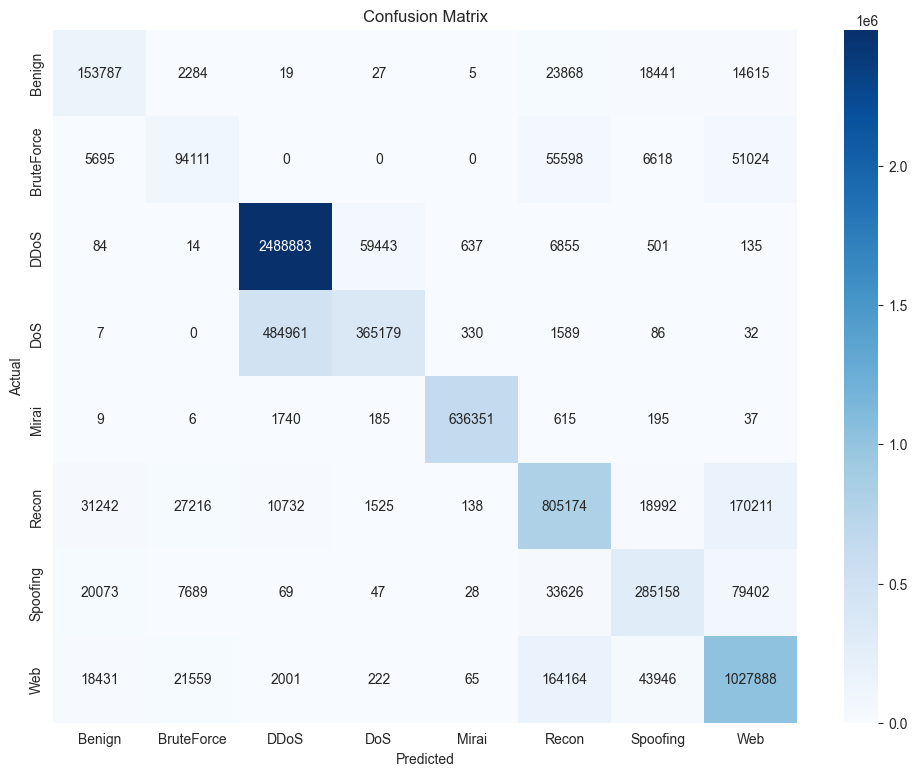

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

class_names = label_encoder.classes_
plt.figure(figsize=(12, 9))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_seaborn.png', dpi=500, bbox_inches='tight')
plt.show()

# Convert confusion matrix array to a DataFrame
cm_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Export the DataFrame to a CSV file
cm_df.to_csv(f'confusion_matrix-{current_uuid}.csv')